In [92]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

In [93]:
alpha = 2e-4
beta = 8e-4
rho0 = 1000
g = 10
horizontal_shear = 0.1

nu = 1e-2
background_diffusivity = 1e-4

thermocline_depth = 500
box_length = 5000e3
box_width = 5000e3
total_depth = 3000

V_s = box_length * box_width * thermocline_depth
V_d = box_length * box_width * (total_depth - thermocline_depth)

T1atm = 0
T2atm = 20
t_atm = 30 * 24 * 3600

evap0 = 1e5

t_circ = 1000

In [94]:
def rho(T: float, S: float):
    return rho0 - alpha * T + beta * S

def richardson_number(delta_rho: float, delta_z: float):
    return (g * delta_rho * delta_z) / (horizontal_shear ** 2 * rho0)

def eddy_diffusivity(delta_rho: float, delta_z: float):

    Ri = richardson_number(delta_rho, delta_z)

    return nu / ((1 + 5 * Ri) ** 2) + background_diffusivity

def evap_func(t: float):
    evap = evap0 * np.exp(- t / 1e11)
    return evap0

def H(x, k=100):
    return 0.5 *((k*x) / (np.sqrt(1 + (k * x) ** 2)) + 1)

In [95]:
def T_offset():
    pass

In [ ]:
def calculate_penman_evaporation(temp, rh, wind_speed, net_radiation):
    """
    Calculates the open-water potential evaporation using the Penman Equation.
    
    Parameters:
    temp_c (float): Air temperature in Celsius
    rh (float): Relative humidity as a percentage (0-100)
    wind_speed (float): Wind speed at 2m height in m/s
    net_radiation (float): Net radiation in W/m^2
    
    Returns:
    float: Potential evaporation in m/s
    """
    temp_c = temp - 273.15

    net_radiation = net_radiation * 24 * 3600 * 1e-6
    # 1. Physical Constants
    # Latent heat of vaporization (approx. 2.45 MJ/kg)
    latent_heat = 2.45 
    # Psychrometric constant (approx. 0.067 kPa/C at sea level)
    gamma = 0.067      
    
    # 2. Saturation Vapor Pressure (es) in kPa (Tetens formula)
    es = 0.6108 * np.exp((17.27 * temp_c) / (temp_c + 237.3))
    
    # 3. Actual Vapor Pressure (ea) in kPa
    ea = es * (rh / 100.0)
    
    # 4. Vapor Pressure Deficit (VPD)
    vpd = es - ea
    
    # 5. Slope of the saturation vapor pressure curve (delta)
    delta = (4098 * es) / ((temp_c + 237.3)**2)
    
    # 6. Wind Function f(u) 
    # Standard Penman wind function: 0.26 * (1 + 0.54 * u)
    f_u = 0.26 * (1 + 0.54 * wind_speed)
    
    # 7. Aerodynamic term (Drying power of air)
    ea_term = f_u * vpd
    
    # 8. Radiation term in mm/day equivalent
    # Converting MJ/m2/day to mm/day by dividing by latent heat
    rn_mm = net_radiation / latent_heat
    
    # 9. Penman Equation Formula:
    # Eo = (delta * Rn + gamma * Ea) / (delta + gamma)
    evaporation = (delta * rn_mm + gamma * ea_term) / (delta + gamma)
    
    return evaporation / (1000 * 24 * 3600)

def dSdt(T, S, depth):
    E = calculate_penman_evaporation(T, 0.77, 2, 1360 * 0.25)
    return (S * E) / depth 

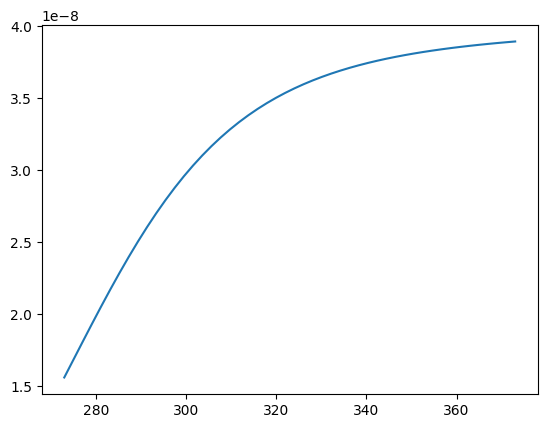

In [97]:
T = np.linspace(273, 373)
E = calculate_penman_evaporation(T, 0.77, 2, 1360)
dSdt = (35 * E) / 500
plt.plot(T, dSdt)

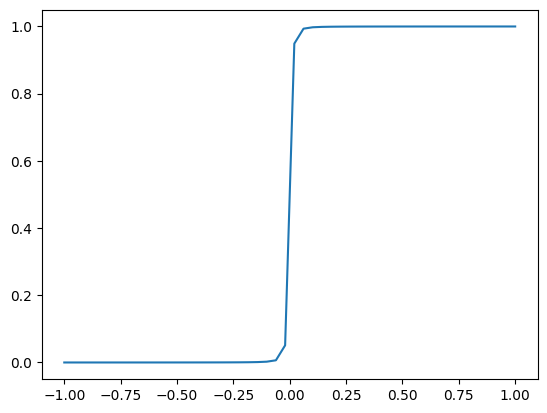

In [98]:
plt.plot(np.linspace(-1, 1), H(np.linspace(-1, 1)))

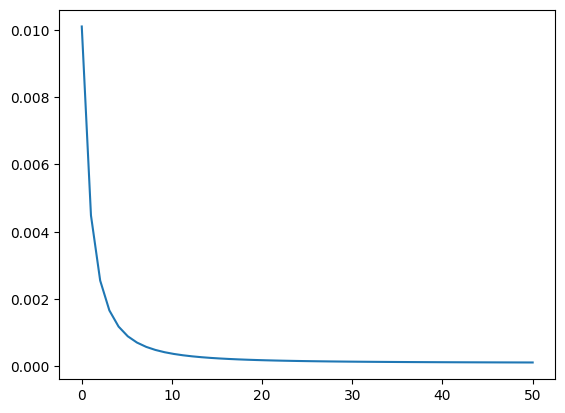

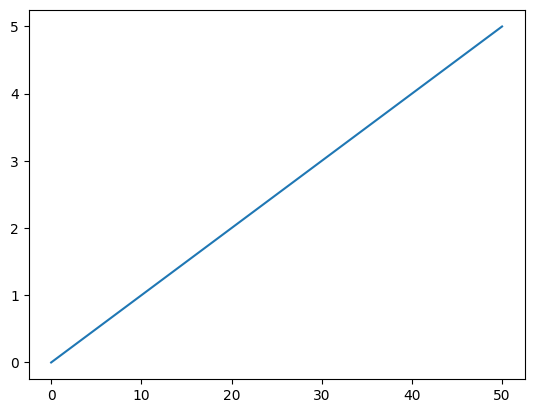

In [99]:
delta_T = np.linspace(0, 50)
delta_rho = alpha * delta_T

w = eddy_diffusivity(delta_rho, thermocline_depth)
Ri = richardson_number(delta_rho, thermocline_depth)

plt.plot(delta_T, w)
plt.show()

plt.plot(delta_T, Ri)
plt.show()

In [100]:
def dY1dt(t: float, Y: list[float]):

    T1s, T1d, T2s, T2d, S1s, S1d, S2s, S2d = Y
    
    delta_rho1 = rho(T1d, S1d) - rho(T1s, S1s)
    delta_rho2 = rho(T2d, S2d) - rho(T2s, S2s)

    K1 = eddy_diffusivity(delta_rho1, thermocline_depth)
    K2 = eddy_diffusivity(delta_rho2, thermocline_depth)

    w1 = K1 / thermocline_depth
    w2 = K2 / thermocline_depth

    psi1 = w1 * box_width * box_length
    psi2 = w2 * box_width * box_length

    evap = 5e-7

    Tmix1 = (K1 * box_width * box_length / thermocline_depth) * (T1s - T1d) * 0
    Tmix2 = (K2 * box_width * box_length / thermocline_depth) * (T2s - T2d) * 0

    Smix1 = (K1 * box_width * box_length / thermocline_depth) * (S1s - S1d) * 0
    Smix2 = (K2 * box_width * box_length / thermocline_depth) * (S2s - S2d) * 0

    psi1 = psi1 * H(delta_rho2 - delta_rho1)
    psi2 = psi2 * H(delta_rho1 - delta_rho2)

    diff_coeff = 2.0e-7

    diff_T_surf = diff_coeff * (T2s - T1s)
    diff_T_deep = diff_coeff * (T2d - T1d)
    diff_S_surf = diff_coeff * (S2s - S1s)
    diff_S_deep = diff_coeff * (S2d - S1d)
    
    dT1s_dt = (psi1 * (T2s - T1s) + psi2 * (T1d - T1s) - Tmix1) / V_s + (T1atm - T1s) / t_atm + diff_T_surf
    dT1d_dt = (psi1 * (T1s - T1d) + psi2 * (T2d - T1d) + Tmix1) / V_d + diff_T_deep
    dT2s_dt = (psi1 * (T2d - T2s) + psi2 * (T1s - T2s) - Tmix2) / V_s + (T2atm - T2s) / t_atm - diff_T_surf
    dT2d_dt = (psi1 * (T1d - T2d) + psi2 * (T2s - T2d) + Tmix2) / V_d - diff_T_deep

    dS1s_dt = (psi1 * (S2s - S1s) + psi2 * (S1d - S1s) - Smix1) / V_s - evap + diff_S_surf
    dS1d_dt = (psi1 * (S1s - S1d) + psi2 * (S2d - S1d) + Smix1) / V_d - diff_S_deep
    dS2s_dt = (psi1 * (S2d - S2s) + psi2 * (S1s - S2s) - Smix2) / V_s + evap - diff_S_surf
    dS2d_dt = (psi1 * (S1d - S2d) + psi2 * (S2s - S2d) + Smix2) / V_d - diff_S_deep
    
    return [dT1s_dt, dT1d_dt, dT2s_dt, dT2d_dt, dS1s_dt, dS1d_dt, dS2s_dt, dS2d_dt]

In [101]:
def dY2dt(t: float, Y: list[float]):

    T1, T2, S1, S2 = Y

    rho1 = rho(T1, S1)
    rho2 = rho(T2, S2)

    psi = (rho1 - rho2) / (rho0 * t_circ)

    dT1_dt = np.abs(psi) * (T2 - T1) + (T1atm - T1) / t_atm
    dT2_dt = - np.abs(psi) * (T2 - T1) + (T2atm - T2) / t_atm
    dS1_dt = np.abs(psi) * (S2 - S1) - evap0
    dS2_dt = - np.abs(psi) * (S2 - S1) + evap0

    return [dT1_dt, dT2_dt, dS1_dt, dS2_dt]

In [102]:
t_end = 1e12

sol = solve_ivp(dY1dt, (0, t_end), [10, 10, 10, 10, 35, 35, 35, 35], method='LSODA')

t1 = sol.t / 3.16e7
T1s, T1d, T2s, T2d, S1s, S1d, S2s, S2d = sol.y

In [103]:
# sol = solve_ivp(dY2dt, (0, t_end), [20, 20, 35, 35], method='RK45')

# t2 = sol.t / 3.16e7
# T1, T2, S1, S2 = sol.y

In [104]:
delta_rho1 = rho(T1d, S1d) - rho(T1s, S1s)
delta_rho2 = rho(T2d, S2d) - rho(T2s, S2s)

w1 = eddy_diffusivity(delta_rho1, thermocline_depth) / thermocline_depth
w2 = eddy_diffusivity(delta_rho2, thermocline_depth) / thermocline_depth

psi1 = w1 * box_width * box_length
psi2 = w2 * box_width * box_length

psi1 = psi1 * H(delta_rho2 - delta_rho1)
psi2 = psi2 * H(delta_rho1 - delta_rho2)

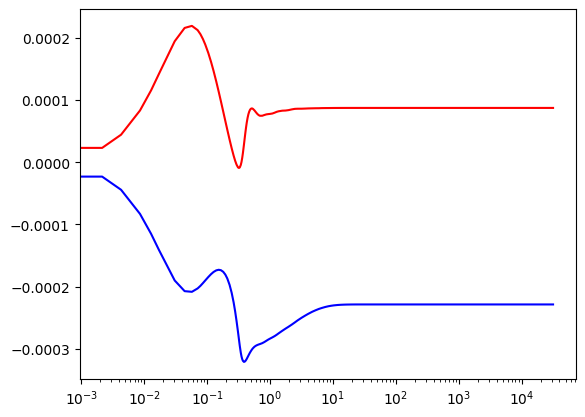

In [105]:
plt.plot(t1, delta_rho1, 'b-')
plt.plot(t1, delta_rho2, 'r-')
plt.xscale('log')

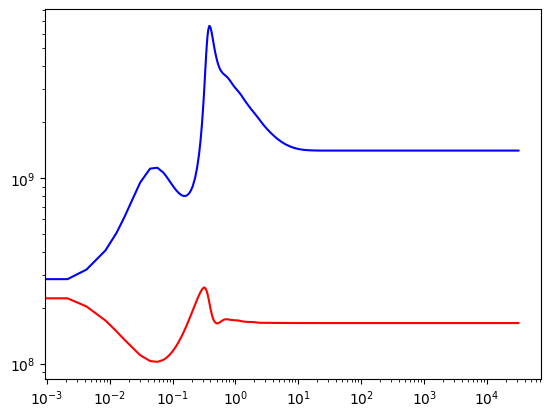

In [106]:
plt.plot(t1, psi1, 'b-')
plt.plot(t1, psi2, 'r-')
plt.xscale('log')
plt.yscale('log')

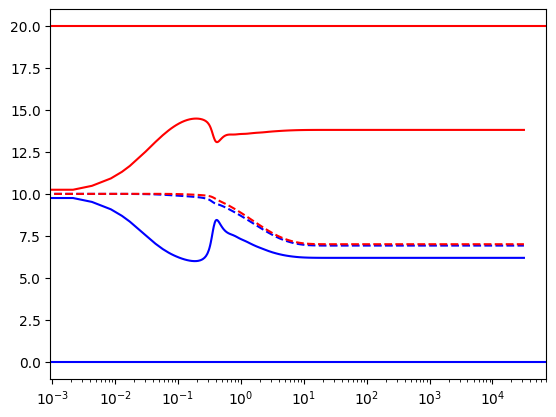

In [107]:
plt.plot(t1, T1s, 'b-')
plt.plot(t1, T1d, 'b--')
plt.plot(t1, T2s, 'r-')
plt.plot(t1, T2d, 'r--')
# plt.plot(t2, T1, 'b:')
# plt.plot(t2, T2, 'r:')
plt.axhline(T1atm, color='blue')
plt.axhline(T2atm, color='red')
plt.xscale('log')

plt.show()

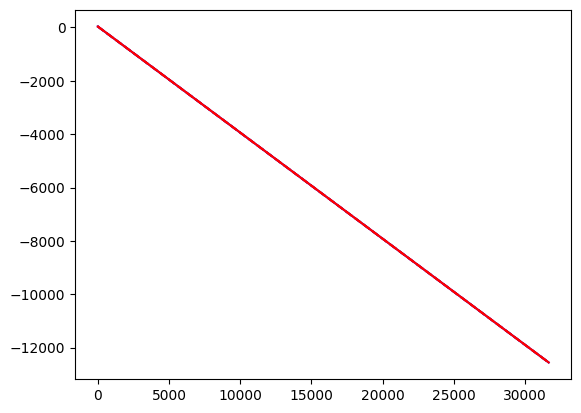

In [108]:
plt.plot(t1, S1s, 'b-')
plt.plot(t1, S1d, 'b--')
plt.plot(t1, S2s, 'r-')
plt.plot(t1, S2d, 'r--')
# plt.plot(t1, evap_func(t1 * 3.16e7) * 3e7, 'k-')
# plt.plot(t2, S1, 'b:')
# plt.plot(t2, S2, 'r:')

plt.show()

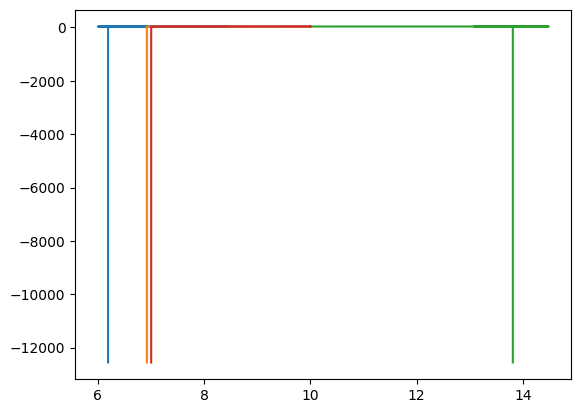

In [109]:
plt.plot(T1s, S1s)
plt.plot(T1d, S1d)
plt.plot(T2s, S2s)
plt.plot(T2d, S2d)